In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

In [7]:
df = pd.read_csv("21-housing.csv")

In [9]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [13]:
df.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [15]:
df["total_bedrooms"]  = df["total_bedrooms"].fillna(df["total_bedrooms"].median())

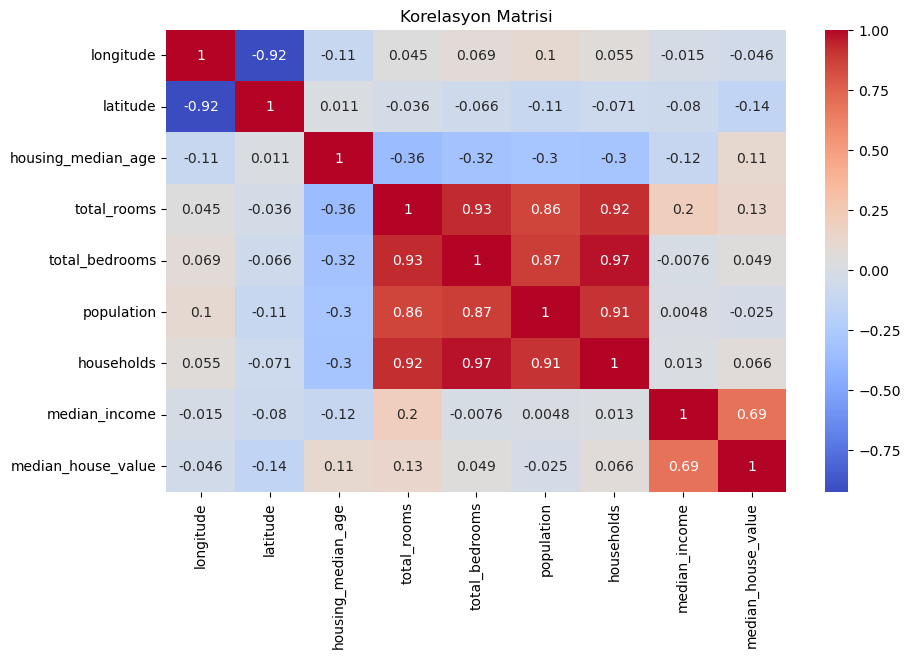

In [17]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Korelasyon Matrisi")
plt.show()


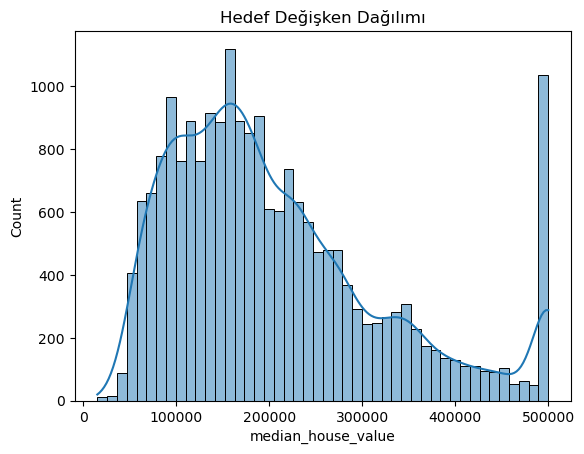

In [19]:
sns.histplot(df['median_house_value'], kde=True)
plt.title("Hedef Değişken Dağılımı")
plt.show()

In [21]:
cat_features = ['ocean_proximity']
num_features = df.drop(columns=['ocean_proximity', 'median_house_value']).columns


In [25]:
X = df.drop('median_house_value', axis=1)
y = df['median_house_value']

cat_features = ['ocean_proximity']
num_features = X.drop(columns=cat_features).columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
pre_no = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
], remainder='passthrough')

X_train_no = pre_no.fit_transform(X_train)
X_test_no = pre_no.transform(X_test)

model_no = XGBRegressor(random_state=42, n_estimators=500, learning_rate=0.1)
model_no.fit(X_train_no, y_train)

y_pred_no = model_no.predict(X_test_no)

r2_no = r2_score(y_test, y_pred_no)
print("🔹 R² (Dönüşümsüz):", round(r2_no, 4))


🔹 R² (Dönüşümsüz): 0.8384


In [29]:
pre_yeo = ColumnTransformer([
    ('num', PowerTransformer(method='yeo-johnson'), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

X_train_yj = pre_yeo.fit_transform(X_train)
X_test_yj = pre_yeo.transform(X_test)

model_yj = XGBRegressor(random_state=42, n_estimators=500, learning_rate=0.1)
model_yj.fit(X_train_yj, y_train)

y_pred_yj = model_yj.predict(X_test_yj)

r2_yj = r2_score(y_test, y_pred_yj)
print("🔹 R² (Yeo-Johnson Dönüşümlü):", round(r2_yj, 4))


🔹 R² (Yeo-Johnson Dönüşümlü): 0.8355


In [33]:
# LightGBM modeli
from lightgbm import LGBMRegressor
model_no = LGBMRegressor(random_state=42)
model_no.fit(X_train_no, y_train)

y_pred_no = model_no.predict(X_test_no)

# Metrikler
r2_no = r2_score(y_test, y_pred_no)
mae_no = mean_absolute_error(y_test, y_pred_no)
rmse_no = np.sqrt(mean_squared_error(y_test, y_pred_no))

print("💡 [Normal Veri] LightGBM Sonuçları:")
print(f"R² Skoru : {r2_no:.4f}")
print(f"MAE      : {mae_no:.2f}")
print(f"RMSE     : {rmse_no:.2f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1846
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 12
[LightGBM] [Info] Start training from score 207194.693738
💡 [Normal Veri] LightGBM Sonuçları:
R² Skoru : 0.8244
MAE      : 32159.12
RMSE     : 47974.55


C:\Users\omerf\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [35]:
model_yj = LGBMRegressor(random_state=42)
model_yj.fit(X_train_yj, y_train)

y_pred_yj = model_yj.predict(X_test_yj)

# Metrikler
r2_yj = r2_score(y_test, y_pred_yj)
mae_yj = mean_absolute_error(y_test, y_pred_yj)
rmse_yj = np.sqrt(mean_squared_error(y_test, y_pred_yj))

print("\n⚙️ [Yeo-Johnson Dönüşümlü Veri] LightGBM Sonuçları:")
print(f"R² Skoru : {r2_yj:.4f}")
print(f"MAE      : {mae_yj:.2f}")
print(f"RMSE     : {rmse_yj:.2f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1844
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 12
[LightGBM] [Info] Start training from score 207194.693738

⚙️ [Yeo-Johnson Dönüşümlü Veri] LightGBM Sonuçları:
R² Skoru : 0.8232
MAE      : 32138.36
RMSE     : 48135.95


C:\Users\omerf\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
